<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap09_4_sentiment_analysis_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 9 - Redes Neurais Artificiais

## 9.4. Estudo de caso: Análise de Sentimentos utilizando uma Rede Neural Profunda

### Tarefa: classificação de polaridade em tweets

Classificar um *tweet* em alguma das três polaridades: positiva (*positive*), negativa (*negative*) e positiva (*neutral*).

### O *corpus*

Para isso, vamos precisar utilizar as bibliotecas keras, tensorflow, numpy, sklearn, matplotlib.

Fonte: [SemEval-2013 Task 2: Sentiment Analysis in Twitter](https://aclanthology.org/S13-2052/)

O *corpus* de tweets empregado nesse estudo de caso podem ser acessados na pasta "corpus_tweets" deste repositório. Segue a especificação de cada arquivo:

*   ```twitter-2013train-A.txt```: conjunto de tweets para treinamento
*   ```twitter-2013dev-A.txt```: conjunto de tweets para validação
*   ```twitter-2013test-A.txt```: conjunto de tweets para testes

In [ ]:
!pip install -U keras
!pip install -U tensorflow

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

Importando as classes necessárias a partir das bibliotecas

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

### Carregamento do corpus para Pandas DataFrames



**PS.:** Mais informações sobre a divisão de um conjunto de dados em treinamento, validação e teste, você encontra nesse [link](https://machinelearningmastery.com/difference-test-validation-datasets/).


In [ ]:
path_train = 'twitter-2013train-A.txt'
path_valid = 'twitter-2013dev-A.txt'
path_test = 'twitter-2013test-A.txt'

In [ ]:
df_train = pd.read_csv(path_train, names=["id","polarity","text"],encoding='utf8', sep='\t')
df_valid = pd.read_csv(path_valid, names=["id","polarity","text"],encoding='utf8', sep='\t')
df_test = pd.read_csv(path_test, names=["id","polarity","text"],encoding='utf8', sep='\t')

In [ ]:
df_train

,id,polarity,text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...
...,...,...,...
9679,103158179306807296,positive,RT @MNFootNg It's monday and Monday Night Foot...
9680,103157324096618497,positive,All I know is the road for that Lomardi start ...
9681,100259220338905089,neutral,"All Blue and White fam, we r meeting at Golden..."
9682,104230318525001729,positive,@DariusButler28 Have a great game agaist Tam...


Informações sobre cada parte do *corpus* de tweets:

In [ ]:
print(f"O conjunto de treinamento possui {df_train.shape} tweets")
print(f"O conjunto de validação possui {df_valid.shape} tweets")
print(f"O conjunto de testes possui {df_test.shape} tweets")

O conjunto de treinamento possui (9684, 3) tweets
O conjunto de validação possui (1654, 3) tweets
O conjunto de testes possui (3547, 3) tweets


### Pré-processamento dos Tweets

Remove o atributo **id**, pois não será necessário o uso desse atributo no processo de classificação.



In [ ]:
df_train.drop(labels=['id'],axis=1)
df_valid.drop(labels=['id'],axis=1)
df_test.drop(labels=['id'],axis=1)

,polarity,text
0,positive,"@jjuueellzz down in the Atlantic city, ventnor..."
1,positive,Musical awareness: Great Big Beautiful Tomorro...
2,neutral,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3,negative,"Kapan sih lo ngebuktiin,jan ngomong doang Susa..."
4,neutral,"Excuse the connectivity of this live stream, f..."
...,...,...
3542,negative,Khaleda Zia's present India visit may have a b...
3543,neutral,"FYI, golf fans: @jameslepp will join Moj on We..."
3544,negative,@__Aniko you think mr.Calle let practice with ...
3545,positive,Don't hide under your desk! It's just a salsa ...


Além disso, por questões do uso dos métodos da classe Sequential no Keras-Tensorflow, convertemos o atributo de classe para o tipo categórico e para cada instância, mapeamos seus valores para números inteiros. Lembre-se que os **modelos de aprendizado de máquina processam apenas números inteiros ou reais**.

In [ ]:
df_train['polarity'] = pd.Categorical(df_train['polarity'])
df_valid['polarity'] = pd.Categorical(df_valid['polarity'])
df_test['polarity'] = pd.Categorical(df_test['polarity'])

y_train = df_train['polarity'].cat.codes
y_valid = df_valid['polarity'].cat.codes
y_test = df_test['polarity'].cat.codes

Vamos ver como e repare que o mapeamento do atributo categórico "polarity" para valores categóricos inteiros ficou como:

*   polaridade "negativa" *(negative)*: valor $0$
*   polaridade "neutra" *(neutral)*: valor $1$
*   polaridade "positiva" *(positive)*: valor $2$

In [ ]:
for i in range(0,5):
    v = df_train['polarity'][i]
    print(f'Valor original da classe {v} Transformação inteira: {y_train[i]}')

Valor original da classe positive Transformação inteira: 2
Valor original da classe negative Transformação inteira: 0
Valor original da classe negative Transformação inteira: 0
Valor original da classe negative Transformação inteira: 0
Valor original da classe neutral Transformação inteira: 1


A seguir, transformamos os valores da classe "polaridade", nossa classe de interesse, para one-hot-encoding. Nessa representação, como temos três classes, utilizaremos três bits, em que para cada instância, apenas um deles estará ativado (com valor $1$) com base na presença do valor classe.

Veja como fica a representação one-hot encoding para cada classe:

*   polaridade "negativa" *(negative)*: valor $0$, one hot encoding: $[1,0,0]$
*   polaridade "neutra" *(neutral)*: valor $1$, one hot encoding: $[0,1,0]$
*   polaridade "positiva" *(positive)*: valor $2$, one hot encoding: $[0,0,1]$

Utilizaremos a função *to_categorical* do Keras para esse propósito (se bem que poderíamos facilmente implementar uma por nossa conta):

In [ ]:
from keras.utils.np_utils import to_categorical

num_classes = 3

y_train_enc = to_categorical(y_train,3)
y_valid_enc = to_categorical(y_valid,3)
y_test_enc = to_categorical(y_test,3)

Apenas verificando como ficou o pré-processamento do atributo de classe:

In [ ]:
for i in range(0,5):
    v = df_train['polarity'][i]
    print(f"Tweet {i}: valor original da classe '{v}'; mapeamento para inteiro: {y_train[i]}; representação one-hot-encoding [{int(y_train_enc[i][0])},{int(y_train_enc[i][1])},{int(y_train_enc[i][2])}]")

Tweet 0: valor original da classe 'positive'; mapeamento para inteiro: 2; representação one-hot-encoding [0,0,1]
Tweet 1: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 2: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 3: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 4: valor original da classe 'neutral'; mapeamento para inteiro: 1; representação one-hot-encoding [0,1,0]


### Extração de características dos tweets

Método Term Frequeny-Inverse Document Frequency (TF-IDF) implementado pela classe *TfidfVectorizer*.

Aqui deve-se tomar o cuidado de calcular o vocabulário apenas no conjunto de treinamento:

In [ ]:
tfidfvectorizer = TfidfVectorizer(norm=None, stop_words='english', max_df=0.95, min_df=2)

tfidfvectorizer.fit(df_train['text'])

tfidf_train = tfidfvectorizer.transform(df_train['text']).toarray()
tfidf_valid = tfidfvectorizer.transform(df_valid['text']).toarray()
tfidf_test = tfidfvectorizer.transform(df_test['text']).toarray()

N = tfidf_train.shape[0]
vocab_size = tfidf_train.shape[1]

print(f'O conjunto de treinamento possui {N} instâncias e um vocabulário de {vocab_size} palavras (termos).')

NameError: ignored

Colocamos as instâncias (juntamente com seus atributos TF-IDF) nas respectivas matrizes $X$ (para cada tipo de dados), em que cada linha de $X$ está associada a um *tweet*. Repare que as classes (labels, rótulos etc) já foram separadas anteriormente e estão armazenadas nas variáveis ```y```. Por exemplo, a instância de treinamento $\mathbf{x_i}$, denotada por ```X_train[i]``` é da classe ```y_train[i]``` $\in \{0,1,2\}$.

In [ ]:
X_train = tfidf_train
X_valid = tfidf_valid
X_test = tfidf_test

### Modelo de Classificação: Rede Neural Profunda

Vamos criar uma rede neural profunda do tipo feed forward multilayer perceptron. O especialista em questão (eu, você etc) decidiu criar uma rede com duas camadas intermediárias: a primeira contendo $20$ neurônios e a segunda contendo $10$ neurônios.



In [ ]:
number_of_neurons_layer1 = 20
number_of_neurons_layer2 = 10

Em seguida, criamos o modelo baseado na rede neural. Observe que agora temos um problema de classificação multi-classe e, por isso, a camada de saída contém três neurônios, em que cada um está associado com uma das possíveis classe ("positive", "negative", "neutral"). Isso significa que o $k$-ésimo neurônio da camada de saída produz na saída a probabilidade de classificação de uma instância para a classe $k$.

In [ ]:
model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_dim=vocab_size, activation="tanh"))
model.add(Dense(number_of_neurons_layer2,activation="tanh"))
model.add(Dense(3,activation="sigmoid"))

O ajuste do modelo para o treinamento consiste em utilizarmos um otimizador da classe SGD (*Stochastic Gradient Descent*), em que colocamos aleatoriamente um valor da taxa de aprendizado ```learning_rate=0.001```.

Outra alteração se trata da função *loss* (que calcula o erro da modelo). Como temos um problema de classificação multiclasse, temos que empregar a função ```categorical_crossentropy```.

In [ ]:
sgd = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(X_train,y_train_enc,validation_data=(X_valid,y_valid_enc),epochs=30)

Epoch 1/30
303/303 [==============================] - 3s 9ms/step - loss: 1.0758 - accuracy: 0.4208 - val_loss: 1.0637 - val_accuracy: 0.4444
Epoch 2/30
303/303 [==============================] - 2s 8ms/step - loss: 1.0080 - accuracy: 0.4975 - val_loss: 1.0367 - val_accuracy: 0.4837
Epoch 3/30
303/303 [==============================] - 2s 7ms/step - loss: 0.9687 - accuracy: 0.5382 - val_loss: 1.0190 - val_accuracy: 0.4940
Epoch 4/30
303/303 [==============================] - 2s 8ms/step - loss: 0.9399 - accuracy: 0.5625 - val_loss: 1.0049 - val_accuracy: 0.5097
Epoch 5/30
303/303 [==============================] - 3s 9ms/step - loss: 0.9158 - accuracy: 0.5829 - val_loss: 0.9921 - val_accuracy: 0.5242
Epoch 6/30
303/303 [==============================] - 2s 7ms/step - loss: 0.8943 - accuracy: 0.6002 - val_loss: 0.9802 - val_accuracy: 0.5357
Epoch 7/30
303/303 [==============================] - 2s 8ms/step - loss: 0.8742 - accuracy: 0.6140 - val_loss: 0.9690 - val_accuracy: 0.5435
Epoch 

Vamos analisar o comportamento da função *loss* no decorrer das épocas:

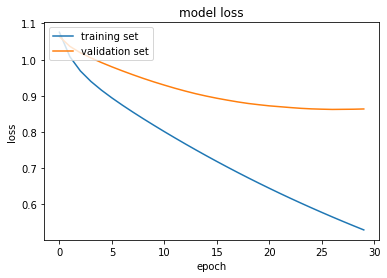

In [ ]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']


plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

O comportamento acima das curvas de loss mostra que o modelo aprende bem os padrões dos dados de treinamento, ganhando mais confiança nas suas classificações. Já a curva para os dados de validação (desconhecidos para o treinamento do modelo) mostram que a *loss* se estabiliza após algumas épocas.

**O que fazer para melhorar?**

Dá para fazer muita coisa...

*   Otimização dos hiperparâmetros: altere a quantidade de camadas intermediárias, a quantidade de neurônios em cada camada intermediária, a quantidade de épocas de treinamento, o algoritmo de otimização (veja [aqui](https://keras.io/api/optimizers/) outros otimizadores);
*   Etapas de pré-processamento dos *tweets*: remoção de URLs, @'s, etc...
*   A caracterização dos *tweets* (por exemplo, o [BERT](https://keras.io/examples/nlp/text_extraction_with_bert/)!)...


### Avaliação de performance utilizando os dados de teste

Agora fazemos a classificação das instâncias do conjunto de teste utilizando o método *predict*. Observe que uma matriz é gerada na saída, em que cada linha representa um *tweet* e as colunas representam:


*   Coluna $0$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "0" (polaridade negativa)
*   Coluna $1$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "1" (polaridade neutra)
*   Coluna $2$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "2" (polaridade positiva)



In [ ]:
y = model.predict(tfidf_test)
y

array([[0.28323925, 0.36455244, 0.56240934],
       [0.2587081 , 0.27768308, 0.7726947 ],
       [0.37565696, 0.74888754, 0.45494932],
       ...,
       [0.40348127, 0.65766186, 0.5104213 ],
       [0.11433679, 0.3026824 , 0.7258324 ],
       [0.36048415, 0.5728992 , 0.53748167]], dtype=float32)

De maneira genérica, podemos calcular argmax das probabilidades, tomando-se as colunas como referência. Suponha que todas as probabilidades estejam na variável ```y_prob```, em que cada linha se trata de uma instância e teremos três colunas:

*   ```y_prob[i][0]```: estimativa da probabilidade de classificar a $i$-ésima instância  de ```X_test``` como sendo da classe "0"
*   ```y_prob[i][1]```: estimativa da probabilidade de classificar a $i$-ésima instância de ```X_test``` como sendo da classe "1"
*   ```y_prob[i][2]```: estimativa da probabilidade de classificar a $i$-ésima instância de ```X_test``` como sendo da classe "2"

Assim, com o uso de $argmax$, para cada instância $i$ podemos obter o índice $j$ da coluna associada à classe com a maior probabilidade:

In [ ]:
y_prob = model.predict(tfidf_test)
y_pred = np.argmax(y_prob,axis=1)

Vamos imprimir os resultados da classificação de *tweets* para os dados de teste:

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.16      0.25       559
           1       0.58      0.81      0.68      1513
           2       0.70      0.61      0.65      1475

    accuracy                           0.63      3547
   macro avg       0.63      0.53      0.53      3547
weighted avg       0.64      0.63      0.60      3547



Outra possibilidade é o uso do método *evaluate*:



In [ ]:
print(model.evaluate(tfidf_test,y_test_enc))

111/111 [==============================] - 0s 2ms/step - loss: 0.8355 - accuracy: 0.6264
[0.8354759216308594, 0.6264448761940002]
